# Deep Learning for Bioacoustics 101*

*A simple example to get you going

<br><br>

Emmanuel Dufourq

<a href=http://www.sun.ac.za/english/data-science-and-computational-thinking/research/ds4es>Data Science for Eco-Systems Research Group</a>

<a href=http://www.sun.ac.za/english/data-science-and-computational-thinking>School for Data Science and Computational Thinking - Stellenbosch University</a>


<a href=http://ie.sun.ac.za/>Department of Industrial Engineering - Stellenbosch University</a>

<a href=https://aims.ac.za/>African Institute for Mathematical Sciences</a>

<hr>

[25]

## Learning Outcomes (in order)

* Understand basic audio processing

* Annoate one short audio file with presence and absence timestamps
* Create a small binary dataset of spectrograms and targets (presence/absence)
* Learn about a simple/silly way to augment our small dataset
* Train a convolutional neural network on the dataset
* Predict on a new file
* Predict using a sliding window approach on a entire file
* Export the predictions and visualise them in Sonic Visualiser

<br><br>



## Download files needed from Google Drive

It will ask you to authenticate with your Google account.

In [ ]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download files
downloaded = drive.CreateFile({'id':"14DhekSGDAGFBr2QmVPhPjlgsrafGT0Ii"})
downloaded.GetContentFile('ISEC2022_EDufourq.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('ISEC2022_EDufourq.zip', 'r') as zip_file:
    zip_file.extractall()

# Imports

In [1]:
# Audio things
# ------------
import librosa
import librosa.display
from IPython.display import Image

# Neural network things
# ---------------------
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Other things
# -------------
from scipy import signal
import numpy as np
import scipy
import matplotlib.pyplot as plt
!pip install SoundFile
!pip install yattag
from IPython.display import Audio
import pandas as pd
import math
import random
import pandas as pd
from itertools import count
from xml.dom import minidom
from yattag import Doc, indent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yattag: filename=yattag-1.14.0-py3-none-any.whl size=15659 sha256=947091d24aa1223a3863128c1c4771d086536cabba97f4ec43f6a2068f1ad738
  Stored in directory: /root/.cache/pip/wheels/4d/32/61/f205e276a280e24c3fca996bd956781b2a0fbad498161e53f4
Successfully built yattag


<br><br>
# Download an audio file

### Collared Flycatcher <i>Ficedula albicollis</i>

Recorded in : Újezd, Zlín

Bird was seen during recording.

1) Go to: https://xeno-canto.org/720758

2) Click on "Download audio file"

3) Rename the file to something easier :) how about: XC720758.mp3

4) Drag and drop into Sonic Visualiser (press G to display the spectrogram)

5) Pretty picture below




<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Collared_flycatcher_%28Ficedula_albicollis%29.jpg/1280px-Collared_flycatcher_%28Ficedula_albicollis%29.jpg width="500" height="400">



# File basics - learning how to access a full file and specific parts

### Read audio file using librosa (Python library)

In [3]:
librosa_audio, librosa_sample_rate = librosa.load('XC720758.mp3', sr = 48000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


### Check sampling rate

In [4]:
librosa_sample_rate

48000

### File type?

In [5]:
type(librosa_audio)

numpy.ndarray

### Length of data

In [6]:
len(librosa_audio)

9460319

### Duration of audio

In [7]:
len(librosa_audio)/librosa_sample_rate

197.08997916666667

### Playing back audio

In [8]:
Audio(data=librosa_audio, rate=librosa_sample_rate)

### Plotting amplitude values (for entire file)

Text(0, 0.5, 'Amplitude')

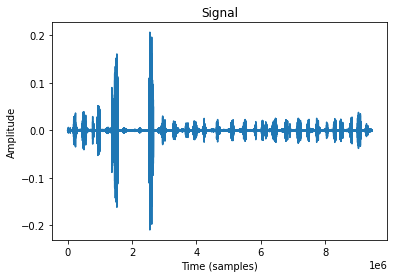

In [ ]:
plt.plot(librosa_audio)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

### Plotting amplitude values (for first second)

Going from index 0 to 48,000 (sampling rate * 1 second)

Text(0, 0.5, 'Amplitude')

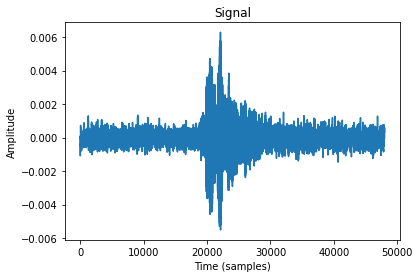

In [ ]:
plt.plot(librosa_audio[0:48000*1])
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

### Plotting amplitude values (for seconds 1 to 2) [neater]

Text(0, 0.5, 'Amplitude')

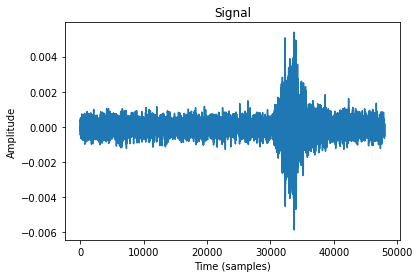

In [ ]:
plt.plot(librosa_audio[librosa_sample_rate*1:librosa_sample_rate*2])
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

### Playing back a short clip (seconds 1 to 6)

In [ ]:
Audio(data=librosa_audio[librosa_sample_rate*1:librosa_sample_rate*6], rate=librosa_sample_rate)

<br><br><br>
## Creating a spectrogram of the entire file

Why are we learning about this? 

<[33]>

In [ ]:
S = librosa.feature.melspectrogram(librosa_audio, sr=librosa_sample_rate, hop_length=256, n_mels=128)

In [ ]:
S.shape

(128, 36955)

How is '36955' determined? Take the sampling rate and find out how many small windows will be extracting by using the hop size. Then multiple by the total number of seconds

In [ ]:
math.ceil((48000/256)*197.08997916666667)

36955

So far a 2 second clip, it would be:

In [ ]:
math.ceil((48000/256)*2)

375

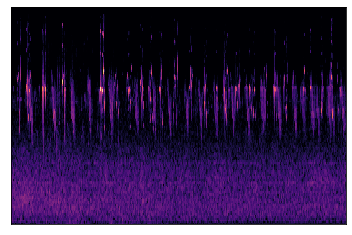

In [ ]:
librosa.display.specshow(librosa.power_to_db(S))

<br><br>
## Creating a spectrogram for seconds 1 to 6


In [ ]:
S = librosa.feature.melspectrogram(librosa_audio[librosa_sample_rate*1:librosa_sample_rate*6], 
                                   sr=librosa_sample_rate,
                                  hop_length=256, n_mels=128)

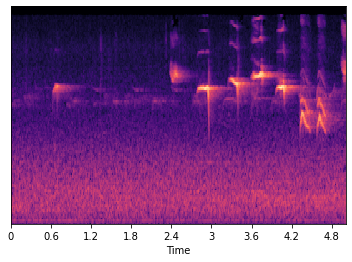

In [ ]:
librosa.display.specshow(librosa.power_to_db(S), x_axis='time', sr=librosa_sample_rate,hop_length=256)

## Linear scale (above was Mel scale)


In [ ]:
S.shape

(128, 938)

In [ ]:
S = librosa.stft(librosa_audio[librosa_sample_rate*1:librosa_sample_rate*6],hop_length=256)

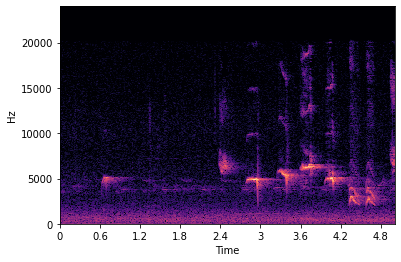

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S)),
                               y_axis='hz', x_axis='time', ax=ax, sr=librosa_sample_rate,hop_length=256)

In [ ]:
S.shape

(1025, 938)

### A small note on the difference in spectrogram sizes

(128,938) vs (1025, 938)

## What do we know so far:

1) How to read a file

2) How to access parts of a file

3) How to create spectrograms

<[40]>
<br><br><br>
<hr>

## Detour on blending files together as a tool for data augmentation (increasing dataset size)

### Getting a segment of audio which *does* contain the Collared Flycatcher vocalisation.

Getting a clip/segment of seconsd 10 to 12.

How do we know there is a call between 10 and 12? I checked on Sonic Visualiser

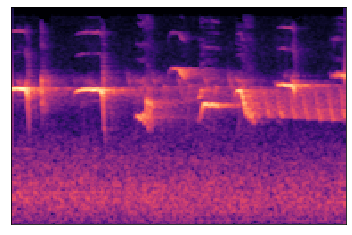

In [ ]:
data_segment_1 = librosa_audio[librosa_sample_rate*10:librosa_sample_rate*12]
S = librosa.feature.melspectrogram(data_segment_1, sr=librosa_sample_rate)
librosa.display.specshow(librosa.power_to_db(S))

In [ ]:
Audio(data=data_segment_1, rate=librosa_sample_rate)

### Getting a segment of audio which *does not* contain the Collared Flycatcher vocalisation.

Getting seconds 39 to 41.

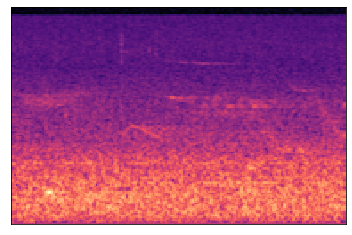

In [ ]:
data_segment_2 = librosa_audio[librosa_sample_rate*152:librosa_sample_rate*154]
S = librosa.feature.melspectrogram(data_segment_2, sr=librosa_sample_rate)
librosa.display.specshow(librosa.power_to_db(S))

In [ ]:
Audio(data=data_segment_2, rate=librosa_sample_rate)

## Combining both together

A weighted combination of both clips

In [ ]:
data_segment_3 = data_segment_1*0.5+ data_segment_2*8.0

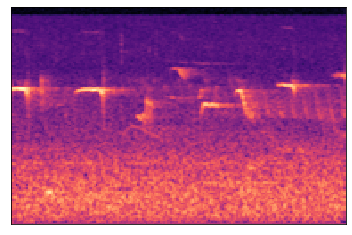

In [ ]:
S = librosa.feature.melspectrogram(data_segment_3, sr=librosa_sample_rate)
librosa.display.specshow(librosa.power_to_db(S))

In [ ]:
Audio(data=data_segment_3, rate=librosa_sample_rate)

## End of detour
<hr>

<br><br><br><br>

<[42]>

# Now let's annotate a small "simple" dataset by looking at sonic visualiser

1) Open Sonic Visualiser

2) Drag and drop the file

3) Let's look for presence and absence times

(I already made one for simplicity, calls.csv)

* Typically, we would annotate start and stop
* assumption, duration of call is at least 2 seconds

In [ ]:
df = pd.read_csv('calls.csv')

Here "start" represents the start time (seconds) that contains/does not contain a call

In [ ]:
df

Start     Label
0       3  presence
1      10  presence
2      19  presence
3      29  presence
4      39   absence
5      40   absence
6      41   absence
7      42   absence
8      49   absence
9      53  presence
10    152   absence
11    126  presence
12    133  presence

### Now that we have this dataframe, the idea is to be able to use code to extract segments of audio for us to build a dataset

### In Python, we can iterate over this dataframe to get the time and label

<[32]>

In [ ]:
for item,row in df.iterrows():
    print (row['Start'])
    print (row['Label'])

3
presence
10
presence
19
presence
29
presence
39
absence
40
absence
41
absence
42
absence
49
absence
53
presence
152
absence
126
presence
133
presence


## Next, we build our dataset

We need to create two variables, ```X``` (to contain the spectrograms) and ```Y``` (contain the target presence or absence).

In our simple example, we will ensure that each example in ```X``` is 2 seconds long.

We are expanding on the code above:

***1) Iterate over our dataframe, one row at a time***

***2) Get the start time (seconds) and convert this to it's corresponding amplitude value by multiplying by the sample rate***

a) If the "label" is a presence, then we create a spectrogram based on the start time, and we create a target of "1" to denote presence.

b) If the "label" is a absence, then we create a spectrogram based on the start time, and we create a target of "0" to denote absence.

***3) Go to the next row in the dataframe and keep repeating***

In [ ]:
X = []
Y = []

duration = 2

for item,row in df.iterrows():
    
    # Get the start time for this "row"
    start_seconds = row['Start']
    
    # Compute the corresponding amplitude value
    start_index = start_seconds * librosa_sample_rate
    
    # The end position is calculated by adding 2 seconds (times sample rate)
    end_index = start_index + librosa_sample_rate * duration

    # Extract a clip and create a spectrogram
    S = librosa.feature.melspectrogram(librosa_audio[start_index:end_index], 
                                       sr=librosa_sample_rate)
    
    # Accumulate these spectrograms in variable X
    X.append(S)
    
    # If this "row" is a presence event, then set the taget to "1"
    if row['Label'] == 'presence':
        Y.append('1')
        
    # Otherwise, this "row" is an absence event, then set the taget to "1"
    else:

        Y.append('0')

X = np.asarray(X)
Y = np.asarray(Y)

## Now we have 13 examples, each example is a spectrogram

In [ ]:
X.shape

(13, 128, 188)

## Each example has a corresponding "target"

In [ ]:
Y.shape

(13,)

<hr>

<[45]>

<[50]>

## Questions about our dataset?

<hr>

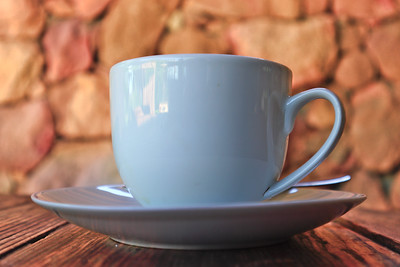

In [ ]:
Image('coffee.jpg')

<br><br><br>

## Look at our dataset

Look at the element 0 in our dataset (in python an array starts from 0)

It is a presence event, displayed by the "1".

1


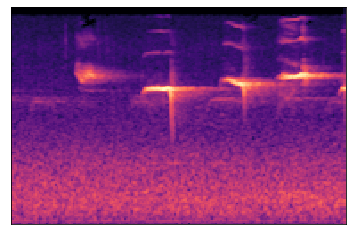

In [ ]:
librosa.display.specshow(librosa.power_to_db(X[0]))
print(Y[0])

Look at the element 5 in our dataset.

It is a absence event, displayed by the "0".

0


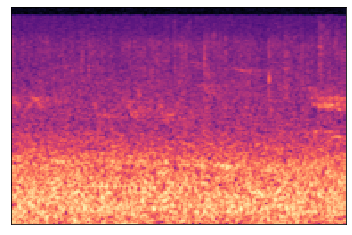

In [ ]:
librosa.display.specshow(librosa.power_to_db(X[5]))
print(Y[5])

## Now we have a training dataset! 

<img 
     src=https://c.tenor.com/1rGPG7GkOVwAAAAC/beau-happy.gif>

### Okay, but we don't have a lot of data, only 13 examples of presence and absence...

<br><br><br>

## Simple augmentation (shifting)

1) Create two lists (```augmented_X```, ```augmented_Y```) to store our newly created examples.

2) Repeat a number of times:

3) Go through each example in our data and... :

4) Take the spectrogram and shift it a bit to the right

5) Add the shifted spectrogram to our augmented spectrogram variable, ```augmented_X```. The same value for the target is used and stored in ```augmented_Y```.

In [ ]:
def augment(number):
    
    augmented_X = []
    augmented_Y = []
    
    # Repeat a bunch of times.
    for i in range (0, number):
        
        # Iterate over all the data we have (spectrogram and targets)
        for index, spectrogram, target in zip(count(), X, Y):

            # Randomly decide how much to shift by
            shift = random.randint(0,len(spectrogram))
            
            # Perform the shift
            spec_shifted = np.roll(spectrogram, shift)
            
            # Add the newly created spectrogram to our new variable
            augmented_X.append(spec_shifted)
            
            # The target won't change, so a presence is still a presence,
            # and an absence is still an absence
            augmented_Y.append(int(target))

    augmented_X = np.asarray(augmented_X)
    augmented_Y = np.asarray(augmented_Y)
    
    return augmented_X, augmented_Y

### Create 50 times more examples

In [ ]:
augmented_X, augmented_Y = augment(500)

### Now we have more data!

In [ ]:
augmented_X.shape

(6500, 128, 188)

In [ ]:
augmented_Y.shape

(6500,)

<[54]>

<br><br><br>

# Time to start diving into CNN details

## Adding depth

The library we use to create models expect that we specify the depth of the input. In our case we have spectrogram images with a depth of 1. The code below essentially just adds a depth of 1 to the shape of the data.

***Before:*** (6500, 128, 188)

***After:*** (6500, 128, 188, 1)

In [ ]:
augmented_X = np.reshape(augmented_X, (augmented_X.shape[0],augmented_X.shape[1],augmented_X.shape[2],1))

In [ ]:
augmented_X.shape

(6500, 128, 188, 1)

## One hot encoding targets

We can't work with just 1's and 0's as our targets. We can to encode this into a sequence of zeroes and ones (some of you know this as dummy variables). 

A "1" is encoded as [0, 1]

A "0" is encoded as [1, 0]

### Before

In [ ]:
print (augmented_Y[0])
print (augmented_Y[450])

1
0


### Perform the encoding

In [ ]:
augmented_Y = to_categorical(augmented_Y, num_classes = 2)

### After

In [ ]:
print (augmented_Y[0])
print (augmented_Y[450])

[0. 1.]
[1. 0.]


### Our target values have all been encoded, all 6500 target values now are encoded using two values

In [ ]:
augmented_Y.shape

(6500, 2)

<br><br><br>
## Network time!

We need to define the input (to tell the network what to expect), in our case (128, 188, 1) spectrograms.

<[57]>

## What do we know so far:

1) How to read a file

2) How to access parts of a file

3) How to create spectrograms

4) How to read a csv file and extract parts of the file as presence or absence events

5) How to increase the amount of data (in a silly way)

6) How to prepare the data so that it is ready for Tensorflow

In [ ]:
INPUT_SHAPE = (128,188, 1)

# Starting point
model = Sequential()

# Create one convolutional layer
model.add(Conv2D(filters = 32, kernel_size = 3, input_shape = INPUT_SHAPE, activation = 'relu'))

# Create one max pooling layer
model.add(MaxPool2D(pool_size = 2))

# Create another convolutional layer
model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))

# Create another max pooling layer
model.add(MaxPool2D(pool_size=2))
  
model.add(Flatten())

# Here we create 16 fully connected units
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 32, activation='relu'))
    
# The output
model.add(Dense(2, activation = 'softmax'))

# Here we tell the model how to improve/update the weights
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

## Next, we define how many iterations we'll train/optimise for

In [ ]:
model.fit(augmented_X, augmented_Y, epochs=4)

Epoch 1/4
204/204 [==============================] - 15s 19ms/step - loss: 0.0438 - accuracy: 0.9880
Epoch 2/4
204/204 [==============================] - 4s 18ms/step - loss: 2.0984e-05 - accuracy: 1.0000
Epoch 3/4
204/204 [==============================] - 4s 19ms/step - loss: 1.0307e-05 - accuracy: 1.0000
Epoch 4/4
204/204 [==============================] - 4s 19ms/step - loss: 5.8160e-06 - accuracy: 1.0000


<[65]>

<br><br>

## Here is a small function that we can use to print a spectrogram and see what the model predicts

1) It prints the spectrogram

2) It inputs the spectrogram into the model's ```predict``` function and gets the output from the mode

3) We can convert the model output into a binary decision (presence or absence)

In [ ]:
def check (index):
    
    librosa.display.specshow(librosa.power_to_db(augmented_X[index,:,:,0]))

    softmax = model.predict(np.reshape(augmented_X[index], (1,128,188,1)))
    np.argmax(softmax,-1)

    print('softmax', softmax)
    print('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

Check if the model did well on data point 500?

softmax [[9.999939e-01 6.078225e-06]]
absence


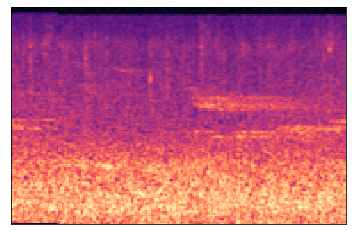

In [ ]:
check(500)

Check if the model did well on data point 300?

softmax [[3.1588853e-22 1.0000000e+00]]
presence


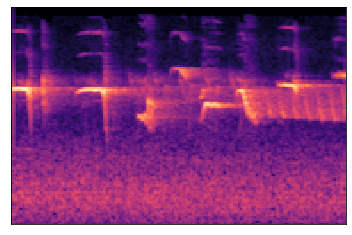

In [ ]:
check(300)

Check if the model did well on data point 100?

softmax [[0. 1.]]
presence


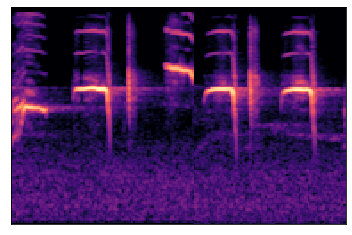

In [ ]:
check(100)

Check if the model did well on data point 10?

softmax [[9.9999368e-01 6.3024754e-06]]
absence


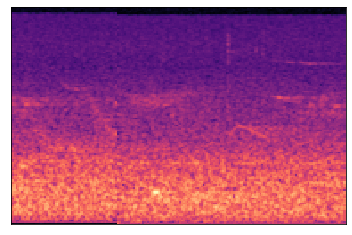

In [ ]:
check(10)

<hr>

<[1:00]>

<[1:05]>

## Questions about the network and predictions?


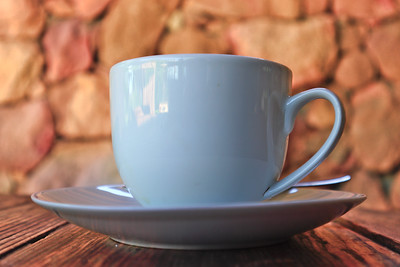

In [ ]:
Image('coffee.jpg')

## Above results seem interesting! 

## But we are not really evaluating our performance in a fair way. We are evaluating on files which were used during training!

### Instead, let us download another two recordings, and apply the model to a new file and see what happens.


<br>

<hr>

## Let's download another recording of the same flycatcher recorded in Mursko Središće, Croatia

1) Go to: https://xeno-canto.org/727811

2) Click on "Download audio file"

3) Rename the file to something easier :) how about: 727811.mp3

## Read audio file

In [ ]:
librosa_audio, librosa_sample_rate = librosa.load('XC727811.mp3', sr = 44100)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Now, let's predict on seconds 10 to 12. Why? 

* We can see in Sonic Visualiser (or other software) that there is a call there, so does the model detect the call?

* Rememebr the CNN takes in 2 second input

softmax [[0. 1.]]
presence


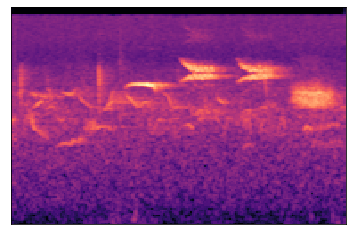

In [ ]:
S = librosa.feature.melspectrogram(librosa_audio[10*librosa_sample_rate:librosa_sample_rate*12], 
                                   sr=librosa_sample_rate, hop_length=471, n_mels=128)
librosa.display.specshow(librosa.power_to_db(S))

softmax = model.predict(np.reshape(S, (1,128,188,1)))
np.argmax(softmax,-1)

print('softmax', softmax)
print('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

## Now, let's predict on seconds 1 to 3.

* We can see in Sonic Visualiser (or other software) that there is a call there, so does the model detect the call?

softmax [[0. 1.]]
presence


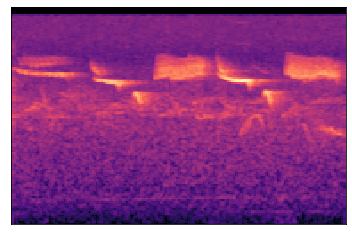

In [ ]:
S = librosa.feature.melspectrogram(librosa_audio[1*librosa_sample_rate:librosa_sample_rate*3], 
                                   sr=librosa_sample_rate, hop_length=471, n_mels=128)
librosa.display.specshow(librosa.power_to_db(S))

softmax = model.predict(np.reshape(S, (1,128,188,1)))
np.argmax(softmax,-1)

print('softmax', softmax)
print('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

<hr>

<br>

## Let's download another recording of the same flycatcher recorded in Poland

1) Go to: https://xeno-canto.org/689995 (Bird seen)

2) Click on "Download audio file"

3) Rename the file to something easier :) how about: XC689995.mp3

## Read audio file

In [ ]:
librosa_audio, librosa_sample_rate = librosa.load('XC689995.mp3', sr = 48000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Now, let's predict on seconds 5 to 7.

* We can see in Sonic Visualiser (or other software) that there is no call there, so does the model agree?

softmax [[9.9999261e-01 7.3659726e-06]]
absence


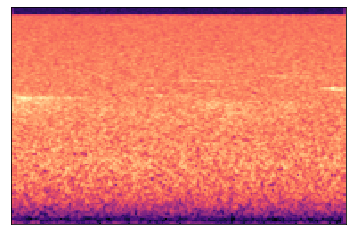

In [ ]:
S = librosa.feature.melspectrogram(librosa_audio[5*librosa_sample_rate:librosa_sample_rate*7], sr=librosa_sample_rate, n_mels=128)
librosa.display.specshow(librosa.power_to_db(S))

softmax = model.predict(np.reshape(S, (1,128,188,1)))
np.argmax(softmax,-1)

print('softmax', softmax)
print('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

## Now, let's predict on seconds 0 to 2.

* We can see in Sonic Visualiser (or other software) that there is a call there, so does the model detect the call?

softmax [[0. 1.]]
presence


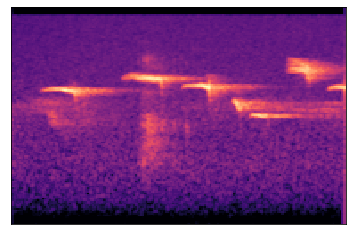

In [ ]:
S = librosa.feature.melspectrogram(librosa_audio[0:librosa_sample_rate*2], sr=librosa_sample_rate, n_mels=128)
librosa.display.specshow(librosa.power_to_db(S))

softmax = model.predict(np.reshape(S, (1,128,188,1)))
np.argmax(softmax,-1)

print('softmax', softmax)
print('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

<[1:12]>

<br><br><br>

<hr>

## Okay so it seems like when we target areas in a record that we get the result we expect. This isn't a fair way to evaluate as we are looking in particular areas. Can't we write code to predict on the entire file instead?

1) We determine the duration (seconds) of the file

2) Compute the total number of segments we can obtain (duration - length of segment, to avoid going out of bounds)

3) Create a list to store the predictions

4) Loop over the entire file (from 0 to the value from step (2))

a) the start position is allocated (starts at zero and increments by 1)

b) the end position (start + length of segment)

c) extract the segment and create a spectrogram

d) input the spectrogram into the model and get the output

e) convert output into binary format and append to prediction list

In [ ]:
def predict_on_entire_file(audio, sample_rate):
    
    # Duration of file
    file_duration = len(audio)/sample_rate
    
    # Number of segments
    segments = math.floor(file_duration) - 2
    
    # Store predictions in this list
    predictions = []

    # Loop over the file and work in small "segments"
    for position in range (0, segments):

        # Determine start of segment
        start_position = position
        
        # Determine end of segment
        end_position = start_position + 2

        print('start position:', start_position)
        print('end position:', end_position)

        # Extract a 2 second segment from the audio file
        audio_segment = audio[start_position*librosa_sample_rate:end_position*librosa_sample_rate]
        
        # Create the spectrogram
        S = librosa.feature.melspectrogram(audio_segment, sr=sample_rate, n_mels=128)

        # Input spectrogram into model
        softmax = model.predict(np.reshape(S, (1,128,188,1)))
        
        print ('model output:', softmax)
        
        # Binary output
        binary_prediction = np.argmax(softmax,-1)
        
        print ('binary output:', binary_prediction[0])
        
        # Append result
        predictions.append('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')
        
        print()
        
    return predictions

In [ ]:
predictions = predict_on_entire_file(librosa_audio, librosa_sample_rate)

start position: 0
end position: 2
model output: [[0. 1.]]
binary output: 1

start position: 1
end position: 3
model output: [[0. 1.]]
binary output: 1

start position: 2
end position: 4
model output: [[0. 1.]]
binary output: 1

start position: 3
end position: 5
model output: [[0. 1.]]
binary output: 1

start position: 4
end position: 6
model output: [[7.626069e-26 1.000000e+00]]
binary output: 1

start position: 5
end position: 7
model output: [[9.9999261e-01 7.3659726e-06]]
binary output: 0

start position: 6
end position: 8
model output: [[9.9999034e-01 9.6068889e-06]]
binary output: 0

start position: 7
end position: 9
model output: [[1.9277372e-27 1.0000000e+00]]
binary output: 1

start position: 8
end position: 10
model output: [[1.1423272e-31 1.0000000e+00]]
binary output: 1

start position: 9
end position: 11
model output: [[7.7834167e-28 1.0000000e+00]]
binary output: 1

start position: 10
end position: 12
model output: [[1.0329043e-24 1.0000000e+00]]
binary output: 1

start po

## We can store our predictions in a dataframe and get the index position where there was a presence detected

The result represents the starting time (seconds) of a detected call.

Reminder, the file is XC689995.mp3

In [ ]:
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
       21, 22, 23, 24, 31, 32, 33, 34, 35, 40, 41, 43, 44, 45, 46, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       75, 76, 77, 78, 79])

## Let's group consecutive detection together

In [ ]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

## Here are the detectioned grouped together

### How does this compare when we open up the file in Sonic Visualiser?

The last file we opened was XC689995.mp3

In [ ]:
group_consecutives(prediction_indices)

[[0, 1, 2, 3, 4],
 [7, 8, 9, 10, 11, 12],
 [14, 15, 16, 17, 18, 19],
 [21, 22, 23, 24],
 [31, 32, 33, 34, 35],
 [40, 41],
 [43, 44, 45, 46],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68],
 [75, 76, 77, 78, 79]]

Looks good: (see below)

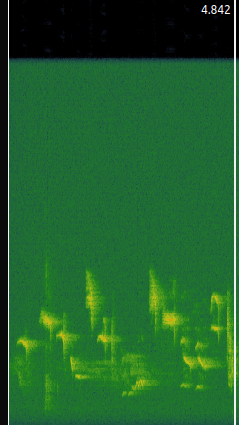

In [ ]:
Image('pred1.png')

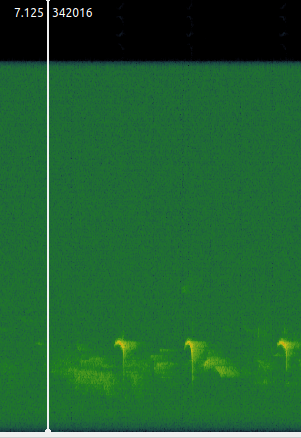

In [ ]:
Image('pred2.png')

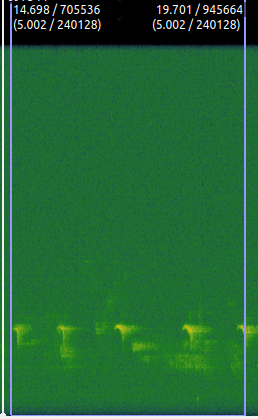

In [ ]:
Image('pred3.png')

## That file wasn't too great as it didn't have too many parts with no calls.

### let's try another file

XC647464.mp3

In [ ]:
# Load the file
librosa_audio, librosa_sample_rate = librosa.load('XC647464.mp3', sr = 48000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
# Predict
predictions = predict_on_entire_file(librosa_audio, librosa_sample_rate)

start position: 0
end position: 2
model output: [[9.9999225e-01 7.8018593e-06]]
binary output: 0

start position: 1
end position: 3
model output: [[0. 1.]]
binary output: 1

start position: 2
end position: 4
model output: [[0. 1.]]
binary output: 1

start position: 3
end position: 5
model output: [[1.0000000e+00 2.4580324e-14]]
binary output: 0

start position: 4
end position: 6
model output: [[1.0000000e+00 1.3513536e-20]]
binary output: 0

start position: 5
end position: 7
model output: [[0. 1.]]
binary output: 1

start position: 6
end position: 8
model output: [[0. 1.]]
binary output: 1

start position: 7
end position: 9
model output: [[0. 1.]]
binary output: 1

start position: 8
end position: 10
model output: [[0. 1.]]
binary output: 1

start position: 9
end position: 11
model output: [[0. 1.]]
binary output: 1

start position: 10
end position: 12
model output: [[0. 1.]]
binary output: 1

start position: 11
end position: 13
model output: [[9.9999547e-01 4.5168354e-06]]
binary outpu

In [ ]:
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([ 1,  2,  5,  6,  7,  8,  9, 10, 17, 18, 19, 20, 21, 27, 28, 29, 34,
       35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])

Reminder, the file is XC647464.mp3

In [ ]:
group_consecutives(prediction_indices)

[[1, 2],
 [5, 6, 7, 8, 9, 10],
 [17, 18, 19, 20, 21],
 [27, 28, 29],
 [34, 35],
 [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]]

Looks good! (see below)

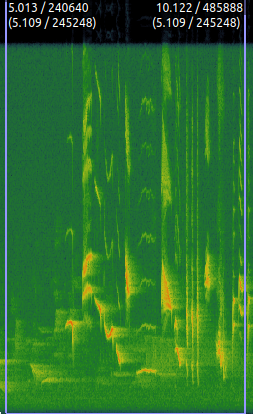

In [ ]:
Image('pred4.png')

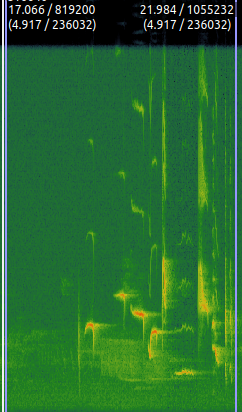

In [ ]:
Image('pred5.png')

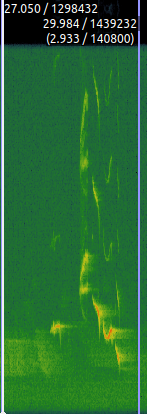

In [ ]:
Image('pred7.png')

## What about a file that has no flycatcher vocalisations?

In [ ]:
# Load the file
librosa_audio, librosa_sample_rate = librosa.load('20210207_010000.WAV', sr = 48000)

In [ ]:
# Predict
predictions = predict_on_entire_file(librosa_audio, librosa_sample_rate)

Streaming output truncated to the last 5000 lines.
start position: 198
end position: 200
model output: [[1.0000000e+00 2.6857188e-17]]
binary output: 0

start position: 199
end position: 201
model output: [[1.00000e+00 2.12693e-17]]
binary output: 0

start position: 200
end position: 202
model output: [[1.0000000e+00 1.2960067e-17]]
binary output: 0

start position: 201
end position: 203
model output: [[1.0000000e+00 2.2814353e-18]]
binary output: 0

start position: 202
end position: 204
model output: [[1.0000000e+00 1.8581363e-18]]
binary output: 0

start position: 203
end position: 205
model output: [[1.0000000e+00 2.8475353e-18]]
binary output: 0

start position: 204
end position: 206
model output: [[1.0000000e+00 3.9798136e-19]]
binary output: 0

start position: 205
end position: 207
model output: [[1.0000000e+00 4.7256404e-19]]
binary output: 0

start position: 206
end position: 208
model output: [[1.0000000e+00 5.8360587e-18]]
binary output: 0

start position: 207
end position: 2

In [ ]:
df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

array([], dtype=int64)

The list is empty. This means the model didn't find any calls, which is good since the file had no calls!

Reminder, the file is 20210207_010000.WAV

In [ ]:
group_consecutives(prediction_indices)

[[]]

<[60]>

## What about a longer file with only a short part that contains the calls?

In [ ]:
librosa_audio, librosa_sample_rate = librosa.load('longerfile.wav', sr = 48000)

predictions = predict_on_entire_file(librosa_audio, librosa_sample_rate)

df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
prediction_indices

start position: 0
end position: 2
model output: [[1. 0.]]
binary output: 0

start position: 1
end position: 3
model output: [[1. 0.]]
binary output: 0

start position: 2
end position: 4
model output: [[1. 0.]]
binary output: 0

start position: 3
end position: 5
model output: [[1. 0.]]
binary output: 0

start position: 4
end position: 6
model output: [[1. 0.]]
binary output: 0

start position: 5
end position: 7
model output: [[1. 0.]]
binary output: 0

start position: 6
end position: 8
model output: [[1. 0.]]
binary output: 0

start position: 7
end position: 9
model output: [[1. 0.]]
binary output: 0

start position: 8
end position: 10
model output: [[1. 0.]]
binary output: 0

start position: 9
end position: 11
model output: [[1. 0.]]
binary output: 0

start position: 10
end position: 12
model output: [[1. 0.]]
binary output: 0

start position: 11
end position: 13
model output: [[1. 0.]]
binary output: 0

start position: 12
end position: 14
model output: [[1. 0.]]
binary output: 0

star

array([31, 32, 35, 36, 37, 38, 39, 47, 48, 49, 50, 57, 58, 59, 64, 65, 68,
       69, 71, 72, 73, 77, 78, 79, 81, 82, 83])

Reminder, the file is longerfile.wav

In [ ]:
groups = group_consecutives(prediction_indices)
groups

[[31, 32],
 [35, 36, 37, 38, 39],
 [47, 48, 49, 50],
 [57, 58, 59],
 [64, 65],
 [68, 69],
 [71, 72, 73],
 [77, 78, 79],
 [81, 82, 83]]

Looks good! (see below)

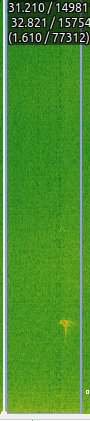

In [ ]:
Image('pred8.png')

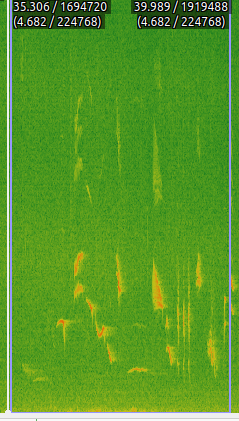

In [ ]:
Image('pred9.png')

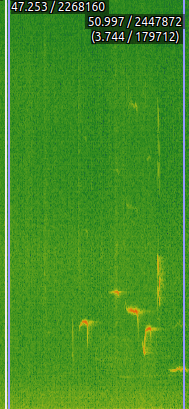

In [ ]:
Image('pred10.png')

<hr>

<[63]>

## Could we visualise the predictions in Sonic Visualiser?

Don't worry about this code. It basically generates a .svl file which can be input into Sonic Visualiser we can visually see the predictions as bounding boxes

In [ ]:
def dataframe_to_svl(dataframe, sample_rate, length_audio_file_frames):

    doc, tag, text = Doc().tagtext()
    doc.asis('<?xml version="1.0" encoding="UTF-8"?>')
    doc.asis('<!DOCTYPE sonic-visualiser>')

    with tag('sv'):
        with tag('data'):

            model_string = '<model id="1" name="" sampleRate="{}" start="0" end="{}" type="sparse" dimensions="2" resolution="1" notifyOnAdd="true" dataset="0" subtype="box" minimum="0" maximum="{}" units="Hz" />'.format(sample_rate, 
                                                                        length_audio_file_frames,
                                                                        sample_rate/2)
            doc.asis(model_string)

            with tag('dataset', id='0', dimensions='2'):

                # Read dataframe or other data structure and add the values here
                # These are added as "point" elements, for example:
                # '<point frame="15360" value="3136.87" duration="1724416" extent="2139.22" label="Cape Robin" />'
                for index, row in dataframe.iterrows():

                    point  = '<point frame="{}" value="{}" duration="{}" extent="{}" label="{}" />'.format(
                        int(int(row['start(sec)'])*sample_rate), 
                        int(row['low(freq)']),
                        int((int(row['end(sec)'])- int(row['start(sec)']))*sample_rate), 
                        int(row['high(freq)']),
                        row['label'])

                    # add the point
                    doc.asis(point)
        with tag('display'):

            display_string = '<layer id="2" type="boxes" name="Boxes" model="1"  verticalScale="0"  colourName="White" colour="#ffffff" darkBackground="true" />'
            doc.asis(display_string)

    result = indent(
        doc.getvalue(),
        indentation = ' '*2,
        newline = '\r\n'
    )

    return result

## Here we create a dataframe that the function above uses to generate the .svl file

The dataframe is displayed under.

The dataframe has a model presence prediction on each row. Each row has the start/end time for the call.

In [ ]:
start_time = []
end_time = []
low_freq = 2000
high_freq = 8000
for group in groups:
    start_time.append(group[0])
    end_time.append(group[-1]+2)
    
df_preds = pd.DataFrame({'start(sec)':start_time, 
              'end(sec)':end_time, 
              'low(freq)':low_freq, 
              'high(freq)':high_freq,
              'label':'predicted'})

Here is the datframe.

In [ ]:
df_preds

start(sec)  end(sec)  low(freq)  high(freq)      label
0          31        34       2000        8000  predicted
1          35        41       2000        8000  predicted
2          47        52       2000        8000  predicted
3          57        61       2000        8000  predicted
4          64        67       2000        8000  predicted
5          68        71       2000        8000  predicted
6          71        75       2000        8000  predicted
7          77        81       2000        8000  predicted
8          81        85       2000        8000  predicted

## Save the .svl file

In [ ]:
xml = dataframe_to_svl(df_preds, librosa_sample_rate, len(librosa_audio))
text_file = open("output.svl", "w")
n = text_file.write(xml)
text_file.close()

## Now we can load it into Sonic Visualiser

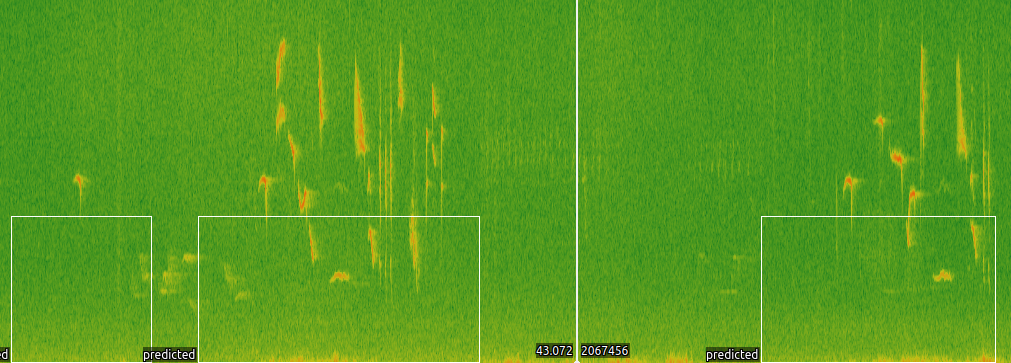

In [ ]:
Image('predictions.png')

## Final note:

1) The model does well on our simple example

2) A lot of things were over-simplified

3) Training on a single audio file is not recommended but possible. It involves doing more complex things to get around this.

4) We used a simple augmentation technique that won't be robust to drastic changes in environment noise

5) Ignoring the last function (which created the file for Sonic Visualiser) you could agree that with a few lines of Python one can automated the detection of calls

6) This is a simple example to provide a starting point into building neural nets for bioacoustic classifiers.

7) Please reach out and stay in touch